In [1]:
import os
from functools import partial

import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from matplotlib import pyplot as plt

from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.util import img_as_float, random_noise
from skimage.metrics import (
    mean_squared_error as mse,
    peak_signal_noise_ratio as psnr,
)
from skimage.restoration import (
    estimate_sigma,
    denoise_wavelet,
    denoise_nl_means,
    denoise_invariant,
    calibrate_denoiser,
    denoise_tv_chambolle,
)

In [2]:
SIGMA = 0.05
NOISES = ["gaussian", "salt_and_pepper", "speckle"]
DENOISERS = ["wavelet", "nl_means", "tv_chambolle"]

In [3]:
def add_noise(image: np.ndarray, noise: str) -> np.ndarray:
    if noise == "gaussian":
        return random_noise(image, mode="gaussian", var=SIGMA**2)
    elif noise == "salt_and_pepper":
        return random_noise(image, mode="s&p", amount=SIGMA**2)
    elif noise == "speckle":
        return random_noise(image, mode="speckle", var=SIGMA**2)

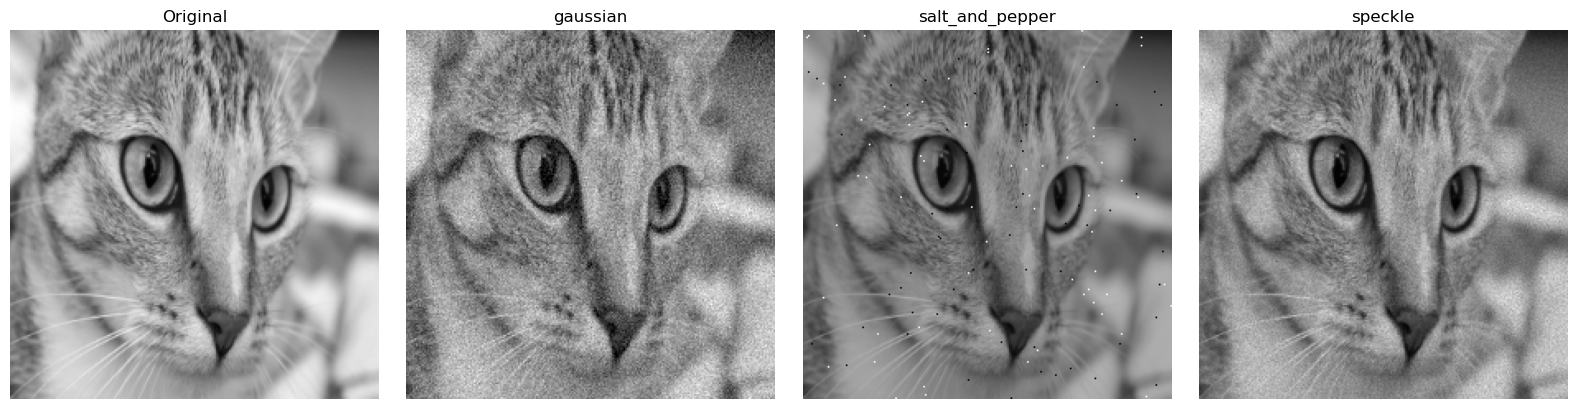

In [4]:
from skimage.data import chelsea

image = chelsea()
image = img_as_float(image)
image = rgb2gray(image)
image = resize(image, (224, 224))

noisy_images = {noise: add_noise(image, noise) for noise in NOISES}

_, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

for i, noise in enumerate(NOISES):
    axes[i+1].imshow(noisy_images[noise], cmap="gray")
    axes[i+1].set_title(noise)
    axes[i+1].axis("off")

plt.tight_layout()
plt.show()

In [5]:
def get_best_tv_params(noisy_image: np.ndarray):
    param_ranges = {'weight': np.arange(0.01, 0.31, 0.02)}

    _, (tested_params, losses) = calibrate_denoiser(
        noisy_image,
        denoise_tv_chambolle,
        denoise_parameters=param_ranges,
        extra_output=True,
    )

    min_loss = np.min(losses)
    best_params = tested_params[np.argmin(losses)]

    return min_loss, best_params

def get_best_wavelet_params(noisy_image: np.ndarray):
    param_ranges = {'sigma': np.arange(0.01, 0.31, 0.03)}

    _denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)

    _, (tested_params, losses) = calibrate_denoiser(
        noisy_image,
        _denoise_wavelet,
        denoise_parameters=param_ranges,
        extra_output=True,
    )

    min_loss = np.min(losses)
    best_params = tested_params[np.argmin(losses)]

    return min_loss, best_params

def get_best_nl_means_params(noisy_image: np.ndarray):
    sigma_est = estimate_sigma(noisy_image)

    param_ranges = {
        'sigma': np.arange(0.6, 1.6, 0.2) * sigma_est,
        'h': np.arange(0.6, 1.4, 0.2) * sigma_est,
    }

    _, (tested_params, losses) = calibrate_denoiser(
        noisy_image,
        denoise_nl_means,
        denoise_parameters=param_ranges,
        extra_output=True,
    )

    min_loss = np.min(losses)
    best_params = tested_params[np.argmin(losses)]

    return min_loss, best_params

In [6]:
def denoise_image(noisy_image: np.ndarray):
    best_params_dict = {
        "wavelet": get_best_wavelet_params(noisy_image),
        "nl_means": get_best_nl_means_params(noisy_image),
        "tv_chambolle": get_best_tv_params(noisy_image),
    }

    best_denoiser = min(best_params_dict, key=lambda x: best_params_dict[x][0])

    denoiser_fn = {
        "wavelet": denoise_wavelet,
        "nl_means": denoise_nl_means,
        "tv_chambolle": denoise_tv_chambolle,
    }[best_denoiser]
    best_loss, best_params = best_params_dict[best_denoiser]

    return denoise_invariant(noisy_image, denoiser_fn, denoiser_kwargs=best_params), best_loss, best_denoiser

In [7]:
def get_metrics(image: np.ndarray, denoised_image: np.ndarray):
    metrics = {
        "mse": mse(image, denoised_image),
        "psnr": psnr(image, denoised_image),
    }

    return metrics

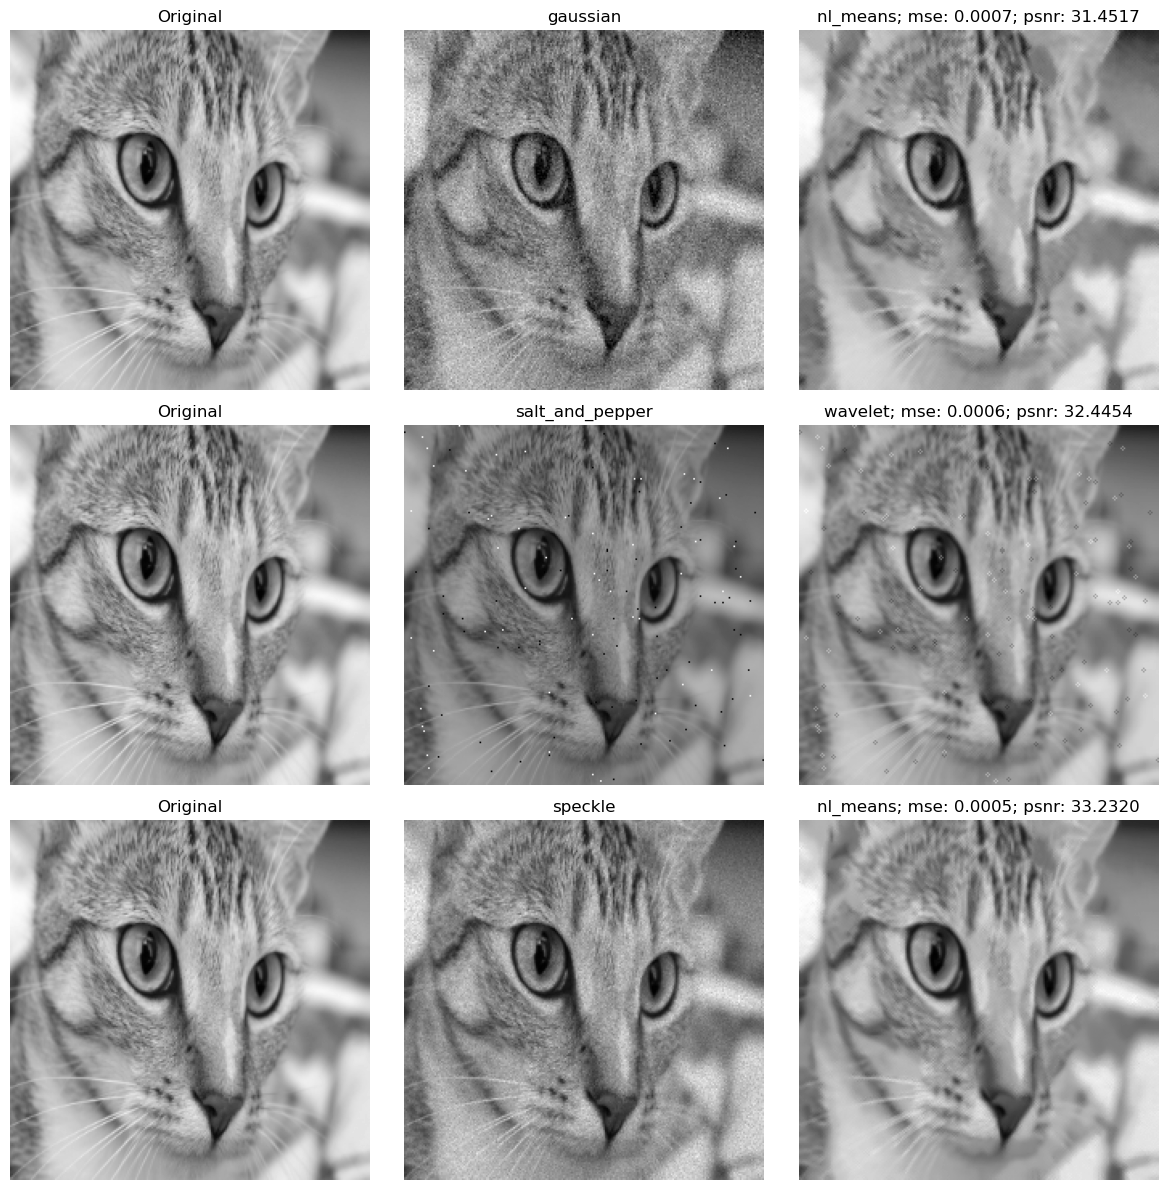

In [8]:
noisy_images = {noise: add_noise(image, noise) for noise in NOISES}

_, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, noise in enumerate(NOISES):
    axes[i, 0].imshow(image, cmap="gray")
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(noisy_images[noise], cmap="gray")
    axes[i, 1].set_title(noise)
    axes[i, 1].axis("off")

    denoised_image, best_loss, best_denoiser = denoise_image(noisy_images[noise])
    metrics = get_metrics(image, denoised_image)

    axes[i, 2].imshow(denoised_image, cmap="gray")
    axes[i, 2].set_title(f"{best_denoiser}; mse: {metrics['mse']:.4f}; psnr: {metrics['psnr']:.4f}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [9]:
CACHE_DIR = "/scratch/public_scratch/gp/DIP/ImageNet-1k/"

val_dataset = load_dataset(
    'imagenet-1k', split='validation', streaming=True,
    cache_dir=CACHE_DIR, trust_remote_code=True
)

In [12]:
results_folder = "../results/denoising/"
os.makedirs(results_folder, exist_ok=True)

i = 0
for sample in tqdm(val_dataset, total=101):
    image = sample["image"]

    if image.mode == "L":
        continue
    elif image.mode != "RGB":
        image = image.convert("RGB")

    image = img_as_float(image)
    image = resize(image, (224, 224))
    gray_image = rgb2gray(image)

    sigma = np.random.uniform(0.03, 0.05)
    noisy_image = random_noise(gray_image, mode="speckle", var=sigma**2)
    noisy_image_title = f"Speckle noise; sigma: {sigma:.4f}"

    denoised_image, _, best_denoiser = denoise_image(noisy_image)
    metrics = get_metrics(gray_image, denoised_image)
    denoised_image_title = f"{best_denoiser}; mse: {metrics['mse']:.4f}; psnr: {metrics['psnr']:.4f}"

    _, axs = plt.subplots(1, 4, figsize=(16, 4))

    for (ax, img, title) in zip(
        axs,
        [image, noisy_image, denoised_image, gray_image],
        ["Original", noisy_image_title, denoised_image_title, "Gray"],
    ):
        ax.imshow(img, cmap="gray" if img.ndim == 2 else None)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join(results_folder, f"{i}.png"), bbox_inches="tight")
    plt.close()

    i += 1
    if i == 101:
        break

100%|██████████| 101/101 [08:19<00:00,  4.94s/it]
